# Tools and data preparation

In [2]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=0218c54a50fdca59f80f6693310f8f572701f414412b1dce92982dfb6c39eba1
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [3]:
pip install -U scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 97.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.0 which is incompatible.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, classification_report
import shap
from lime import lime_tabular
from matplotlib.lines import Line2D
import pickle

In [5]:
# Mengatur tampilan output pandas agar lebih rapi
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
bank = pd.read_csv('/content/drive/MyDrive/Purwadhika/DATASET/data_bank_marketing_campaign.csv')

In [8]:
# Harapan output analisa Bisnis ---
# Membangun model untuk memprediksi apakah klien akan berlangganan deposito berjangka ('yes'/'no').
# Kriteria keberhasilan: Akurasi min 85%, Recall tinggi untuk kelas 'yes'.

# Data Understanding

In [61]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813 entries, 0 to 7812
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       7813 non-null   int64 
 1   job       7813 non-null   object
 2   balance   7813 non-null   int64 
 3   housing   7813 non-null   object
 4   loan      7813 non-null   object
 5   contact   7813 non-null   object
 6   month     7813 non-null   object
 7   campaign  7813 non-null   int64 
 8   pdays     7813 non-null   int64 
 9   poutcome  7813 non-null   object
 10  deposit   7813 non-null   object
dtypes: int64(4), object(7)
memory usage: 671.6+ KB


In [ ]:
# Customer profile
# age
# job
# balance
# housing
# loan


# Marketing data
# contact: Contact communication type.
# month: Last contact month of the year.
# campaign: Number of contacts performed during this campaign and for this client.
# pdays: Number of days after the client was contacted from the previous campaign.
# poutcome: Outcome of the previous marketing campaign.
# deposit: Whether the customer deposits or not.

In [10]:
bank.head()

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit
0,55,admin.,1662,no,no,cellular,jun,2,-1,unknown,yes
1,39,self-employed,-3058,yes,yes,cellular,apr,3,-1,unknown,yes
2,51,admin.,3025,no,no,cellular,may,1,352,other,yes
3,38,services,-87,yes,no,cellular,may,1,-1,unknown,no
4,36,housemaid,205,yes,no,telephone,nov,4,-1,unknown,no


In [11]:
cek_contact = bank['contact'].value_counts()
print(cek_contact)

contact
cellular     5628
unknown      1639
telephone     546
Name: count, dtype: int64


In [12]:
# Hitung jumlah orang yang memiliki pinjaman (housing 'yes' ATAU loan 'yes')
has_any_loan = bank[(bank['housing'] == 'yes') | (bank['loan'] == 'yes')].shape[0]

# Hitung jumlah orang yang tidak memiliki pinjaman (housing 'no' DAN loan 'no')
has_no_loan = bank[(bank['housing'] == 'no') & (bank['loan'] == 'no')].shape[0]

print("Data peminjaman")
print(f'{has_any_loan} orang memiliki setidaknya punya satu jenis pinjaman ')
print(f'{has_no_loan} orang tidak memiliki pinjaman sama sekali')

Data peminjaman
4090 orang memiliki setidaknya punya satu jenis pinjaman 
3723 orang tidak memiliki pinjaman sama sekali


In [60]:
count_job = bank['job'].value_counts()
count_housing = bank['housing'].value_counts()
count_loan = bank['loan'].value_counts()
count_poutcome = bank['poutcome'].value_counts()

print(f"{count_job}\n")
print(f"{count_housing}\n")
print(f"{count_loan}\n")
print(f"{count_poutcome}\n")



job
management       1792
blue-collar      1346
technician       1291
admin.            936
services          658
retired           540
self-employed     280
unemployed        249
student           247
entrepreneur      236
housemaid         184
unknown            54
Name: count, dtype: int64

housing
no     4140
yes    3673
Name: count, dtype: int64

loan
no     6789
yes    1024
Name: count, dtype: int64

poutcome
unknown    5819
failure     848
success     761
other       385
Name: count, dtype: int64



In [14]:
bank.describe()

,age,balance,campaign,pdays
count,7813.000000,7813.000000,7813.000000,7813.000000
mean,41.257264,1512.448611,2.519775,51.408550
std,11.919710,3089.291831,2.727001,108.072739
min,18.000000,-6847.000000,1.000000,-1.000000
25%,32.000000,127.000000,1.000000,-1.000000
50%,39.000000,549.000000,2.000000,-1.000000
75%,49.000000,1684.000000,3.000000,40.000000
max,95.000000,66653.000000,63.000000,854.000000


In [15]:
print("\nDistribusi kelas target 'deposit':")
print(bank['deposit'].value_counts())
print(f"Proporsi kelas 'yes': {bank['deposit'].value_counts(normalize=True)['yes']:.2f}")
print(f"Proporsi kelas 'no': {bank['deposit'].value_counts(normalize=True)['no']:.2f}")
# Catatan: Dataset terlihat sedikit tidak seimbang, 'no' lebih dominan. Ini perlu diperhatikan dalam evaluasi.


Distribusi kelas target 'deposit':
deposit
no     4081
yes    3732
Name: count, dtype: int64
Proporsi kelas 'yes': 0.48
Proporsi kelas 'no': 0.52


In [16]:
# Proporsi data masih cukup balance antara 48:52

In [17]:
print("Cek nilai 'unknown' pada fitur kategorikal dan -1 pada 'pdays':")
for column in bank.select_dtypes(include='object').columns:
    if 'unknown' in bank[column].unique():
        print(f"Kolom '{column}' memiliki {bank[column].value_counts().get('unknown', 0)} nilai 'unknown'.")
if -1 in bank['pdays'].unique():
    print(f"Kolom 'pdays' memiliki {bank['pdays'].value_counts().get(-1, 0)} nilai -1.")

Cek nilai 'unknown' pada fitur kategorikal dan -1 pada 'pdays':
Kolom 'job' memiliki 54 nilai 'unknown'.
Kolom 'contact' memiliki 1639 nilai 'unknown'.
Kolom 'poutcome' memiliki 5819 nilai 'unknown'.
Kolom 'pdays' memiliki 5817 nilai -1.


# Preparation data

In [18]:
# Buat salinan dataset bank
bank_processed = bank.copy()

In [19]:
# Cleaning data dengan tujuan:
# Menangani nilai 'unknown'.
# Nilai 'unknown' pada fitur kategorikal akan diperlakukan sebagai kategori terpisah.

# Menangani -1 pada 'pdays'
# -1 pada 'pdays' berarti klien tidak pernah dihubungi sebelumnya.

In [20]:
bank_processed['pdays'] = bank_processed['pdays'].replace(-1, 0) # Mengubah -1 menjadi 0 setelah fitur biner dibuat

In [21]:
# Cek duplikat, jika ada dihapus
initial_rows = bank_processed.shape[0]
bank_processed.drop_duplicates(inplace=True)
rows_after_duplicates = bank_processed.shape[0]
if initial_rows - rows_after_duplicates > 0:
    print(f"Ditemukan dan dihapus {initial_rows - rows_after_duplicates} baris duplikat.")
else:
    print("Tidak ditemukan duplikat.")

Ditemukan dan dihapus 8 baris duplikat.


In [22]:
# Menangani Outlier:
# Untuk demonstrasi, gunakan visualisasi boxplot dan capping (membatasi nilai ekstrem)
# untuk beberapa fitur numerik yang diketahui memiliki outlier parah seperti 'balance' dan 'duration'. akan menggunakan IQR method for capping

print("\n--- Menangani Outlier (Capping dengan IQR) ---")
numerical_cols_for_outlier = ['balance', 'campaign']
for col in numerical_cols_for_outlier:
    Q1 = bank_processed[col].quantile(0.25)
    Q3 = bank_processed[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Capping outliers
    bank_processed[col] = np.where(bank_processed[col] < lower_bound, lower_bound, bank_processed[col])
    bank_processed[col] = np.where(bank_processed[col] > upper_bound, upper_bound, bank_processed[col])
    print(f"Outlier pada '{col}' telah di-capping.")


--- Menangani Outlier (Capping dengan IQR) ---
Outlier pada 'balance' telah di-capping.
Outlier pada 'campaign' telah di-capping.


In [23]:
# Fitur engineering
# 1. Fitur Berbasis Waktu dari 'month'
# Fitur ini bisa membuat fitur 'month_num' untuk memudahkan ekstraksi atau melihat pola musiman
month_map = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
             'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
bank_processed['month_num'] = bank_processed['month'].map(month_map)
print("Fitur 'month_num' (numerik dari bulan) dibuat.")

Fitur 'month_num' (numerik dari bulan) dibuat.


In [24]:
# 2. Membuat fitur biner 'was_contacted_previously' dari 'pdays
# 0 = No 1=Yes
bank_processed['was_contacted_previously'] = np.where(bank_processed['pdays'] > 0, 1, 0)

print("Fitur 'was_contacted_previously' dibuat.")

Fitur 'was_contacted_previously' dibuat.


In [25]:
# Fitur 'age_group'
bank_processed['age_group'] = pd.cut(bank_processed['age'], bins=[0, 25, 35, 45, 55, 65, np.inf],
                                   labels=['<25', '25-35', '35-45', '45-55', '55-65', '65+'])
print("Fitur 'age_group' dibuat.")

Fitur 'age_group' dibuat.


In [26]:
# drop kolom 'month' yang asli karena sudah diwakili oleh 'month_num'
bank_processed.drop('month', axis=1, inplace=True)

In [27]:
# Tampilkan hasil update Feature Engineering

bank_processed.head()

,age,job,balance,housing,loan,contact,campaign,pdays,poutcome,deposit,month_num,was_contacted_previously,age_group
0,55,admin.,1662.0,no,no,cellular,2.0,0,unknown,yes,6,0,45-55
1,39,self-employed,-2207.5,yes,yes,cellular,3.0,0,unknown,yes,4,0,35-45
2,51,admin.,3025.0,no,no,cellular,1.0,352,other,yes,5,1,45-55
3,38,services,-87.0,yes,no,cellular,1.0,0,unknown,no,5,0,35-45
4,36,housemaid,205.0,yes,no,telephone,4.0,0,unknown,no,11,0,35-45


# Splitting data training dan data test

In [28]:
# Pembagian Data (Training, Validation, Test)")
X = bank_processed.drop('deposit', axis=1)
y = bank_processed['deposit']

# Encoding variabel target 'deposit' (yes=1, no=0)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(f"Mapping target: {list(le.classes_)} -> {list(le.transform(le.classes_))}")

# Bagi data menjadi training (80%) dan temporary (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Bagi temporary menjadi validation (10%) dan test (10%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Ukuran data pelatihan: {X_train.shape[0]} baris")
print(f"Ukuran data validasi: {X_val.shape[0]} baris")
print(f"Ukuran data pengujian: {X_test.shape[0]} baris")


Mapping target: ['no', 'yes'] -> [np.int64(0), np.int64(1)]
Ukuran data pelatihan: 6244 baris
Ukuran data validasi: 780 baris
Ukuran data pengujian: 781 baris


In [29]:
# Identifikasi kolom numerik dan kategorikal untuk preprocessing
numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

if 'age' in numerical_cols: # age_group dibuat dari age, jadi age mungkin ingin diskalakan
    pass # Tetap biarkan age di numerical_cols
# 'age_group' sudah otomatis masuk ke categorical_cols karena perbaikan di atas.

print("\nKolom Numerik untuk Scaling:", numerical_cols)
print("Kolom Kategorikal untuk One-Hot Encoding:", categorical_cols)


Kolom Numerik untuk Scaling: ['age', 'balance', 'campaign', 'pdays', 'month_num', 'was_contacted_previously']
Kolom Kategorikal untuk One-Hot Encoding: ['job', 'housing', 'loan', 'contact', 'poutcome', 'age_group']


In [30]:
# Cek 'was_contacted_previously' dan 'month_num' ada di `numerical_cols`
if 'was_contacted_previously' not in numerical_cols:
    numerical_cols.append('was_contacted_previously')
if 'month_num' not in numerical_cols:
    numerical_cols.append('month_num')

# Kolom 'deposit' tidak ada di data X, jadi tidak perlu di-handle di sini.
# Kolom 'month' sudah dihapus.

In [31]:
# Buat preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols), # Skala numerik
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols) # One-hot encode kategorikal
    ],
    remainder='passthrough' # Biarkan kolom lain yang tidak masuk ke transformer (jika ada)
)

# Modelling

In [32]:
# Definisikan model-model yang akan dicoba
models = {
    'Logistic Regression': LogisticRegression(random_state=42, solver='liblinear'), # liblinear lebih baik untuk dataset kecil
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Support Vector Machine': SVC(probability=True, random_state=42), # probability=True untuk ROC AUC
    'Naive Bayes': GaussianNB()
}

# Pipeline untuk setiap model
pipelines = {}
for name, model in models.items():
    pipelines[name] = Pipeline(steps=[('preprocessor', preprocessor),
                                      ('classifier', model)])


In [33]:
# Melatih model dan evaluasi awal dengan cross-validation
print("\nMelatih dan mengevaluasi model dengan Cross-Validation (5-Fold)...")
results = {}
for name, pipeline in pipelines.items():
    print(f"\nMelatih {name}...")
    # Menggunakan StratifiedKFold untuk menjaga proporsi kelas di setiap fold
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='recall', n_jobs=-1) # Fokus pada recall
    accuracy_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
    results[name] = {'Recall (CV)': np.mean(scores), 'Accuracy (CV)': np.mean(accuracy_scores)}
    print(f"{name} - Recall (Cross-Validation): {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")
    print(f"{name} - Accuracy (Cross-Validation): {np.mean(accuracy_scores):.4f} (+/- {np.std(accuracy_scores):.4f})")


Melatih dan mengevaluasi model dengan Cross-Validation (5-Fold)...

Melatih Logistic Regression...
Logistic Regression - Recall (Cross-Validation): 0.6046 (+/- 0.0172)
Logistic Regression - Accuracy (Cross-Validation): 0.6839 (+/- 0.0043)

Melatih Decision Tree...
Decision Tree - Recall (Cross-Validation): 0.6186 (+/- 0.0164)
Decision Tree - Accuracy (Cross-Validation): 0.6366 (+/- 0.0093)

Melatih Random Forest...
Random Forest - Recall (Cross-Validation): 0.6253 (+/- 0.0201)
Random Forest - Accuracy (Cross-Validation): 0.6904 (+/- 0.0063)

Melatih Gradient Boosting...
Gradient Boosting - Recall (Cross-Validation): 0.6223 (+/- 0.0290)
Gradient Boosting - Accuracy (Cross-Validation): 0.7175 (+/- 0.0155)

Melatih Support Vector Machine...
Support Vector Machine - Recall (Cross-Validation): 0.5851 (+/- 0.0204)
Support Vector Machine - Accuracy (Cross-Validation): 0.6970 (+/- 0.0120)

Melatih Naive Bayes...
Naive Bayes - Recall (Cross-Validation): 0.4749 (+/- 0.0099)
Naive Bayes - Accura

In [34]:
# Menentukan model terbaik berdasarkan recall (sesuai kriteria keberhasilan)
best_model_name = max(results, key=lambda k: results[k]['Recall (CV)'])
print(f"\nModel terbaik berdasarkan Recall Cross-Validation di Training Set: {best_model_name}")

# Penyetelan Hyperparameter untuk model terbaik
print(f"\nPenyetelan Hyperparameter untuk {best_model_name} (menggunakan GridSearchCV)")




Model terbaik berdasarkan Recall Cross-Validation di Training Set: Random Forest

Penyetelan Hyperparameter untuk Random Forest (menggunakan GridSearchCV)


In [62]:
pipelines[best_model_name]

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [36]:
# Definisikan parameter grid untuk model terbaik
param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'classifier__penalty': ['l1', 'l2']
    },
    'Decision Tree': {
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10]
    },
    'Random Forest': {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [10, 20, None],
        'classifier__min_samples_split': [2, 5]
    },
    'Gradient Boosting': {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 7]
    },
    'Support Vector Machine': {
        'classifier__C': [0.1, 1, 10],
        'classifier__gamma': ['scale', 'auto'],
        'classifier__kernel': ['rbf', 'linear']
    },
    'Naive Bayes': {} # GaussianNB biasanya tidak banyak hyperparameter untuk tuning
}

# Lakukan GridSearchCV pada model terbaik
grid_search = GridSearchCV(pipelines[best_model_name], param_grids[best_model_name],
                           cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                           scoring='recall', n_jobs=-1, verbose=1)


In [37]:
grid_search

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'classifier__max_depth': [10, 20, ...], 'classifier__min_samples_split': [2, 5], 'classifier__n_estimators': [100, 200, ...]}"
,scoring,'recall'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [38]:
# Evaluasi model awal (sebelum tuning)
initial_model = pipelines[best_model_name]  # Model awal tanpa tuning

# Menghitung skor recall sebelum tuning
initial_score = cross_val_score(initial_model, X_train, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='recall', n_jobs=-1)
initial_mean_score = initial_score.mean()

print(f"Recall score before hyperparameter tuning: {initial_mean_score:.4f}")

Recall score before hyperparameter tuning: 0.6253


In [39]:
# gunakan X_train saja jika cross-validation
# Untuk tujuan demonstrasi dan mengikuti alur, kita akan GridSearchCV pada X_train.
print("Melakukan Grid Search pada data pelatihan (X_train)...")
grid_search.fit(X_train, y_train)

best_pipeline = grid_search.best_estimator_
print(f"\nHasil Grid Search untuk {best_model_name}:")
print("Best Hyperparameters:", grid_search.best_params_)
print(f"Best Recall score on training data (with CV): {grid_search.best_score_:.4f}")

Melakukan Grid Search pada data pelatihan (X_train)...
Fitting 5 folds for each of 18 candidates, totalling 90 fits

Hasil Grid Search untuk Random Forest:
Best Hyperparameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best Recall score on training data (with CV): 0.6273


In [40]:
# Evaluasi model terbaik pada data validasi (X_val, y_val)
print(f"\n--- Evaluasi Model Terbaik ({best_model_name}) pada Data Validasi ---")
y_val_pred = best_pipeline.predict(X_val)
y_val_proba = best_pipeline.predict_proba(X_val)[:, 1]

print("\nConfusion Matrix (Validation Set):")
print(confusion_matrix(y_val, y_val_pred))

print("\nClassification Report (Validation Set):")
print(classification_report(y_val, y_val_pred, target_names=le.classes_))


--- Evaluasi Model Terbaik (Random Forest) pada Data Validasi ---

Confusion Matrix (Validation Set):
[[316  91]
 [145 228]]

Classification Report (Validation Set):
              precision    recall  f1-score   support

          no       0.69      0.78      0.73       407
         yes       0.71      0.61      0.66       373

    accuracy                           0.70       780
   macro avg       0.70      0.69      0.69       780
weighted avg       0.70      0.70      0.70       780



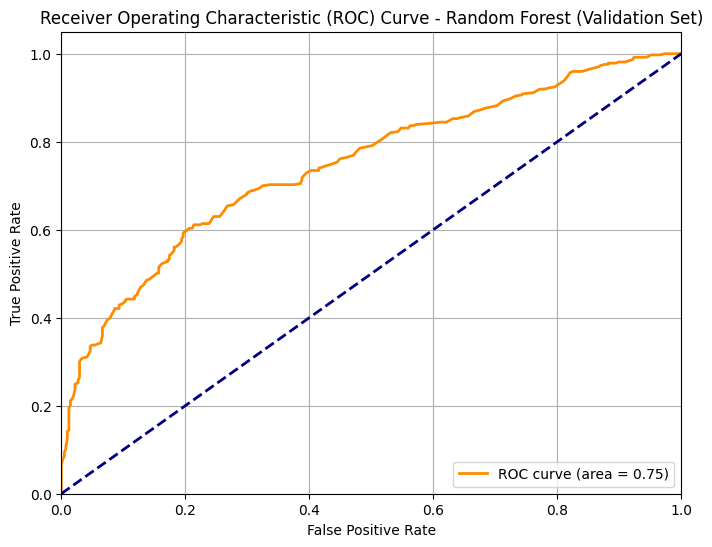

In [41]:
# Visualisasi ROC Curve
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_proba)
roc_auc_val = auc(fpr_val, tpr_val)

plt.figure(figsize=(8, 6))
plt.plot(fpr_val, tpr_val, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC) Curve - {best_model_name} (Validation Set)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [42]:
print(f"Accuracy on Validation Set: {accuracy_score(y_val, y_val_pred):.4f}")
print(f"Precision on Validation Set: {precision_score(y_val, y_val_pred):.4f}")
print(f"Recall on Validation Set: {recall_score(y_val, y_val_pred):.4f}")
print(f"F1-Score on Validation Set: {f1_score(y_val, y_val_pred):.4f}")
print(f"AUC on Validation Set: {roc_auc_val:.4f}")

Accuracy on Validation Set: 0.6974
Precision on Validation Set: 0.7147
Recall on Validation Set: 0.6113
F1-Score on Validation Set: 0.6590
AUC on Validation Set: 0.7459


# Evaluation Model


Evaluasi Model Akhir (Random Forest) pada Data Pengujian (Test Set)


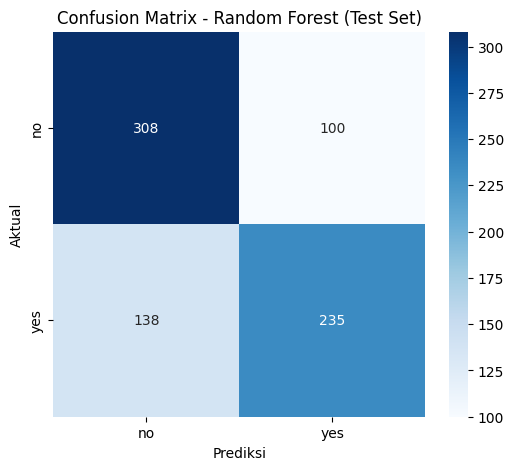

In [43]:
# Evaluasi akhir pada data pengujian (Test Set)
print(f"\nEvaluasi Model Akhir ({best_model_name}) pada Data Pengujian (Test Set)")
y_test_pred = best_pipeline.predict(X_test)
y_test_proba = best_pipeline.predict_proba(X_test)[:, 1]

#Confusion Matrix (Test Set)
cm_test = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title(f'Confusion Matrix - {best_model_name} (Test Set)')
plt.show()

In [44]:
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))

accuracy_test = accuracy_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
roc_auc_test = auc(fpr_test, tpr_test)

print(f"Accuracy on Test Set: {accuracy_test:.4f}")
print(f"Precision on Test Set: {precision_test:.4f}")
print(f"Recall on Test Set: {recall_test:.4f}")
print(f"F1-Score on Test Set: {f1_test:.4f}")
print(f"AUC on Test Set: {roc_auc_test:.4f}")


Classification Report (Test Set):
              precision    recall  f1-score   support

          no       0.69      0.75      0.72       408
         yes       0.70      0.63      0.66       373

    accuracy                           0.70       781
   macro avg       0.70      0.69      0.69       781
weighted avg       0.70      0.70      0.69       781

Accuracy on Test Set: 0.6953
Precision on Test Set: 0.7015
Recall on Test Set: 0.6300
F1-Score on Test Set: 0.6638
AUC on Test Set: 0.7505


In [45]:
# Kembali ke goal apakah bisa mencapai 85% dan berapa recall nya?

# Cek kriteria keberhasilan
if accuracy_test >= 0.85:
    print(f"\nKriteria Keberhasilan (Akurasi): Tercapai! Akurasi model adalah {accuracy_test:.2%}.")
else:
    print(f"\nKriteria Keberhasilan (Akurasi): Tidak Tercapai. Akurasi model adalah {accuracy_test:.2%}. Target >= 85%.")

print(f"Fokus pada Recall untuk kelas 'yes': {recall_test:.4f}")
print("Meningkatkan recall mungkin memerlukan penyesuaian threshold klasifikasi atau strategi penanganan imbalance class (jika signifikan).")



Kriteria Keberhasilan (Akurasi): Tidak Tercapai. Akurasi model adalah 69.53%. Target >= 85%.
Fokus pada Recall untuk kelas 'yes': 0.6300
Meningkatkan recall mungkin memerlukan penyesuaian threshold klasifikasi atau strategi penanganan imbalance class (jika signifikan).


In [46]:
print("\n--- Mendeteksi Overfitting/Underfitting ---")
print(f"Recall Training (Best CV): {grid_search.best_score_:.4f}")
print(f"Recall Validation: {recall_score(y_val, y_val_pred):.4f}")
print(f"Recall Test: {recall_test:.4f}")

if grid_search.best_score_ > recall_test + 0.05: # Ambang batas 5% sebagai indikasi
    print("Potensi Overfitting: Kinerja pelatihan jauh lebih baik daripada kinerja pengujian.")
elif grid_search.best_score_ < 0.60 and recall_test < 0.60: # Ambang batas rendah sebagai indikasi underfitting
    print("Potensi Underfitting: Kinerja model buruk pada pelatihan maupun pengujian.")
else:
    print("Model memiliki keseimbangan yang baik antara bias dan varians (tidak ada overfitting/underfitting yang parah).")


--- Mendeteksi Overfitting/Underfitting ---
Recall Training (Best CV): 0.6273
Recall Validation: 0.6113
Recall Test: 0.6300
Model memiliki keseimbangan yang baik antara bias dan varians (tidak ada overfitting/underfitting yang parah).


In [47]:
best_pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [48]:
X_train_processed = best_pipeline.named_steps['preprocessor'].transform(X_train)


SHAP Summary Plot (Global Feature Importance):


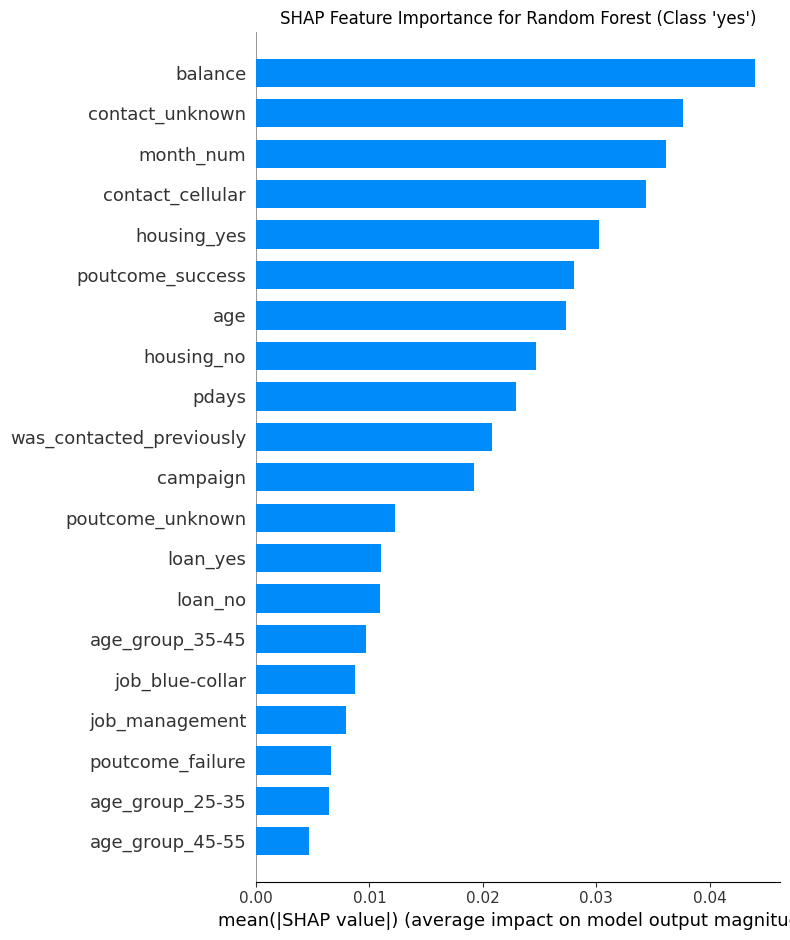


SHAP Dependency Plots (dengan legend):


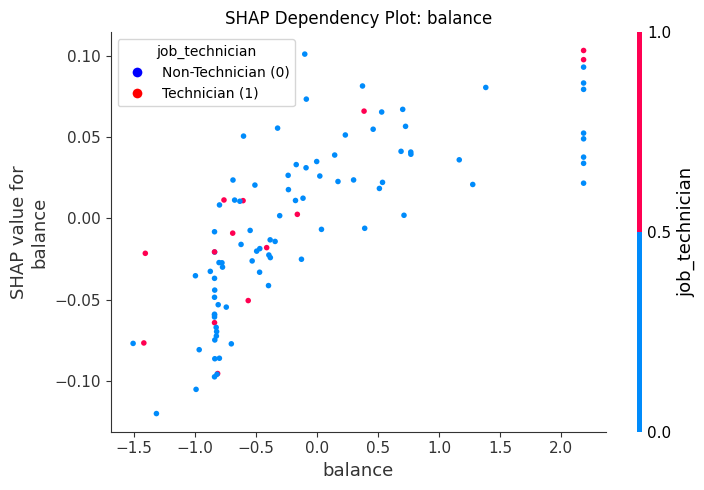

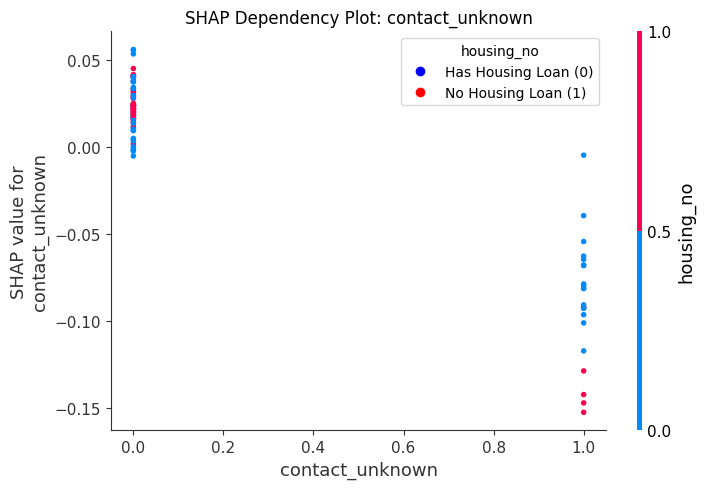

In [49]:
# SHAP
try:
    # Dapatkan nama fitur setelah preprocessing
    ohe_feature_names = list(best_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols))
    feature_names = numerical_cols + ohe_feature_names

    # Transformasi data latih
    X_train_processed = best_pipeline.named_steps['preprocessor'].transform(X_train)
    if hasattr(X_train_processed, 'toarray'):
        X_train_processed = X_train_processed.toarray()

    X_train_processed_df = pd.DataFrame(X_train_processed, columns=feature_names)

    # Pilih explainer sesuai jenis model
    model = best_pipeline.named_steps['classifier']
    if isinstance(model, (RandomForestClassifier, DecisionTreeClassifier, GradientBoostingClassifier)):
        explainer = shap.TreeExplainer(model)
    elif isinstance(model, LogisticRegression):
        explainer = shap.LinearExplainer(model, X_train_processed_df)
    elif isinstance(model, SVC):
        explainer = shap.KernelExplainer(model.predict_proba, shap.sample(X_train_processed_df, 100))
    else:
        explainer = shap.Explainer(model.predict_proba, X_train_processed_df)

    # Transformasi data uji
    X_test_processed = best_pipeline.named_steps['preprocessor'].transform(X_test)
    if hasattr(X_test_processed, 'toarray'):
        X_test_processed = X_test_processed.toarray()

    X_test_processed_df = pd.DataFrame(X_test_processed, columns=feature_names)

    # Sampel sebagian data uji
    sample_X_test_processed = shap.sample(X_test_processed_df, 100, random_state=42)
    shap_values = explainer.shap_values(sample_X_test_processed)

    # Tangani output shap_values tergantung model
    if isinstance(shap_values, list):
        shap_values_to_plot = shap_values[1]
    elif hasattr(shap_values, 'shape') and len(shap_values.shape) == 3:
        shap_values_to_plot = shap_values[:, :, 1]
    elif hasattr(shap_values, 'values'):
        shap_values_to_plot = shap_values.values
    else:
        shap_values_to_plot = shap_values

    # SHAP summary plot
    print("\nSHAP Summary Plot (Global Feature Importance):")
    shap.summary_plot(shap_values_to_plot, sample_X_test_processed, feature_names=feature_names, plot_type="bar", show=False)
    plt.title(f"SHAP Feature Importance for {best_model_name} (Class 'yes')")
    plt.tight_layout()
    plt.show()

    # Ubah sample_X_test_processed ke NumPy array
    X_plot = sample_X_test_processed.values if isinstance(sample_X_test_processed, pd.DataFrame) else sample_X_test_processed

    print("\nSHAP Dependency Plots (dengan legend):")

    # Fitur dan interaksi (warna) untuk dua fitur teratas
    fitur_utama_1 = 'balance'
    fitur_warna_1 = 'job_technician'

    fitur_utama_2 = 'contact_unknown'
    fitur_warna_2 = 'housing_no'

    # Plot 1
    shap.dependence_plot(
        fitur_utama_1,
        shap_values_to_plot,
        sample_X_test_processed,
        interaction_index=fitur_warna_1,
        feature_names=feature_names,
        show=False
    )
    legend_elements_1 = [
        Line2D([0], [0], marker='o', color='w', label='Non-Technician (0)', markerfacecolor='blue', markersize=8),
        Line2D([0], [0], marker='o', color='w', label='Technician (1)', markerfacecolor='red', markersize=8)
    ]
    plt.legend(handles=legend_elements_1, title=fitur_warna_1)
    plt.title(f"SHAP Dependency Plot: {fitur_utama_1}")
    plt.tight_layout()
    plt.show()

    # Plot 2
    shap.dependence_plot(
        fitur_utama_2,
        shap_values_to_plot,
        sample_X_test_processed,
        interaction_index=fitur_warna_2,
        feature_names=feature_names,
        show=False
    )
    legend_elements_2 = [
        Line2D([0], [0], marker='o', color='w', label='Has Housing Loan (0)', markerfacecolor='blue', markersize=8),
        Line2D([0], [0], marker='o', color='w', label='No Housing Loan (1)', markerfacecolor='red', markersize=8)
    ]
    plt.legend(handles=legend_elements_2, title=fitur_warna_2)
    plt.title(f"SHAP Dependency Plot: {fitur_utama_2}")
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Gagal melakukan interpretasi SHAP: {e}")
    print("Pastikan versi SHAP kompatibel dengan versi scikit-learn")
    if 'shap_values_to_plot' in locals():
        print(f"SHAP values to plot shape: {shap_values_to_plot.shape}")


In [50]:
# LIME (Local Interpretable Model-agnostic Explanations)
print("\nMelakukan Interpretasi Model dengan LIME (untuk satu instance)...")
try:
    # Gunakan data yang sudah diproses oleh preprocessor untuk training_data LIME
    # Ini memastikan LIME hanya bekerja dengan data numerik

    # Dapatkan data training yang sudah diproses
    # Ini adalah data yang sama yang digunakan untuk SHAP (setelah ColumnTransformer)
    # Regenerasi jika bagian SHAP di atas dilewati, atau variabel belum didefinisikan.
    # Note: feature_names_shap dan X_train_processed_df_for_shap diharapkan sudah ada dari bagian SHAP
    if 'X_train_processed_df_for_shap' not in locals():
        print("Membangun ulang data yang diproses untuk LIME (biasanya sudah ada dari SHAP)...")
        temp_numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()
        temp_categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

        # Pastikan preprocessor sudah di-fit
        preprocessor.fit(X_train)

        feature_names_shap = temp_numerical_cols + list(preprocessor.named_transformers_['cat'].get_feature_names_out(temp_categorical_cols))

        X_train_processed_for_shap = preprocessor.fit_transform(X_train)
        if hasattr(X_train_processed_for_shap, 'toarray'):
            X_train_processed_for_shap = X_train_processed_for_shap.toarray()
        X_train_processed_df_for_shap = pd.DataFrame(X_train_processed_for_shap, columns=feature_names_shap)


    # Ambil satu instance dari test set untuk dijelaskan (data MENTAH)
    instance_idx = 0
    exp_instance_raw = X_test.iloc[instance_idx]

    # Preprocess the single instance from X_test to match the training_data format for LIME
    # It must be 2D array for transform and then flatten for explain_instance
    exp_instance_processed = preprocessor.transform(exp_instance_raw.to_frame().T)
    if hasattr(exp_instance_processed, 'toarray'):
        exp_instance_processed = exp_instance_processed.toarray()
    exp_instance_processed = exp_instance_processed.flatten() # LIME's explain_instance expects a 1D array

    # Dapatkan label aktual dan prediksi (prediksi masih menggunakan pipeline lengkap untuk data mentah)
    true_label = le.inverse_transform([y_test[instance_idx]])[0]
    # Predict with the full pipeline on the raw instance
    predicted_label = le.inverse_transform([best_pipeline.predict(exp_instance_raw.to_frame().T)])[0]

    # Inisialisasi LIME explainer dengan data training yang sudah diproses (semuanya numerik)
    class_names = le.classes_.tolist()
    explainer_lime = lime_tabular.LimeTabularExplainer(
        training_data=X_train_processed_df_for_shap.values, # <--- Gunakan data training yang sudah diproses (numerik)
        feature_names=feature_names_shap, # <--- Gunakan nama fitur dari data yang sudah diproses
        class_names=class_names,
        mode='classification',
        # Parameter 'categorical_features' dan 'categorical_names' TIDAK diperlukan lagi
        # karena semua fitur di training_data sekarang sudah numerik (setelah one-hot encoding).
        # Parameter discretize_continuous=True (default) atau False bisa disesuaikan,
        # tapi seharusnya tidak menyebabkan masalah 'string to float' lagi.
    )

    # Fungsi prediksi untuk LIME: Sekarang harus menerima numpy array 2D dari data yang SUDAH DIPROSES
    # dan hanya meneruskannya ke classifier dalam pipeline.
    def predict_proba_lime_processed(data_processed):
        # LIME akan memberikan data yang sudah diproses, jadi langsung berikan ke classifier
        # Pastikan data_processed adalah 2D array
        return best_pipeline.named_steps['classifier'].predict_proba(data_processed)

    # Jelaskan instance menggunakan data yang sudah diproses dan fungsi prediksi yang disesuaikan
    explanation = explainer_lime.explain_instance(
        data_row=exp_instance_processed, # <--- Gunakan instance yang sudah diproses (1D numpy array)
        predict_fn=predict_proba_lime_processed, # <--- Gunakan fungsi prediksi yang baru
        num_features=10
    )

    print(f"\nPenjelasan LIME untuk Instance ke-{instance_idx}:")
    # Lebih baik tampilkan raw instance untuk referensi, dan sebutkan bahwa LIME bekerja pada processed data
    print(f"Fitur Asli (mentah): {exp_instance_raw.to_dict()}")
    print(f"Label Aktual: {true_label}, Label Prediksi: {predicted_label}")
    print("Kontribusi Fitur (bobot positif mendukung kelas prediksi):")
    for feature, weight in explanation.as_list():
        print(f"  {feature}: {weight:.4f}")

    # Visualisasikan penjelasan LIME
    explanation.save_to_file('lime_explanation_instance_0.html')
    print("Penjelasan LIME disimpan ke 'lime_explanation_instance_0.html'")

except Exception as e:
    print(f"Gagal melakukan interpretasi LIME: {e}")
    print("Detail error LIME:", e) # Menambahkan detail error untuk debugging lebih lanjut


Melakukan Interpretasi Model dengan LIME (untuk satu instance)...
Membangun ulang data yang diproses untuk LIME (biasanya sudah ada dari SHAP)...


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Penjelasan LIME untuk Instance ke-0:
Fitur Asli (mentah): {'age': 35, 'job': 'technician', 'balance': 204.0, 'housing': 'yes', 'loan': 'no', 'contact': 'cellular', 'campaign': 1.0, 'pdays': 0, 'poutcome': 'unknown', 'month_num': 5, 'was_contacted_previously': 0, 'age_group': '25-35'}
Label Aktual: yes, Label Prediksi: no
Kontribusi Fitur (bobot positif mendukung kelas prediksi):
  poutcome_success <= 0.00: -0.1189
  age_group_65+ <= 0.00: -0.0634
  0.00 < housing_yes <= 1.00: -0.0574
  was_contacted_previously <= -0.59: -0.0568
  0.00 < contact_cellular <= 1.00: 0.0555
  age_group_<25 <= 0.00: -0.0514
  loan_yes <= 0.00: 0.0502
  housing_no <= 0.00: -0.0489
  0.00 < poutcome_unknown <= 1.00: -0.0395
  contact_unknown <= 0.00: 0.0371
Penjelasan LIME disimpan ke 'lime_explanation_instance_0.html'


In [51]:
from IPython.core.display import display, HTML

with open("lime_explanation_instance_0.html", "r") as f:
    html_data = f.read()

display(HTML(html_data))

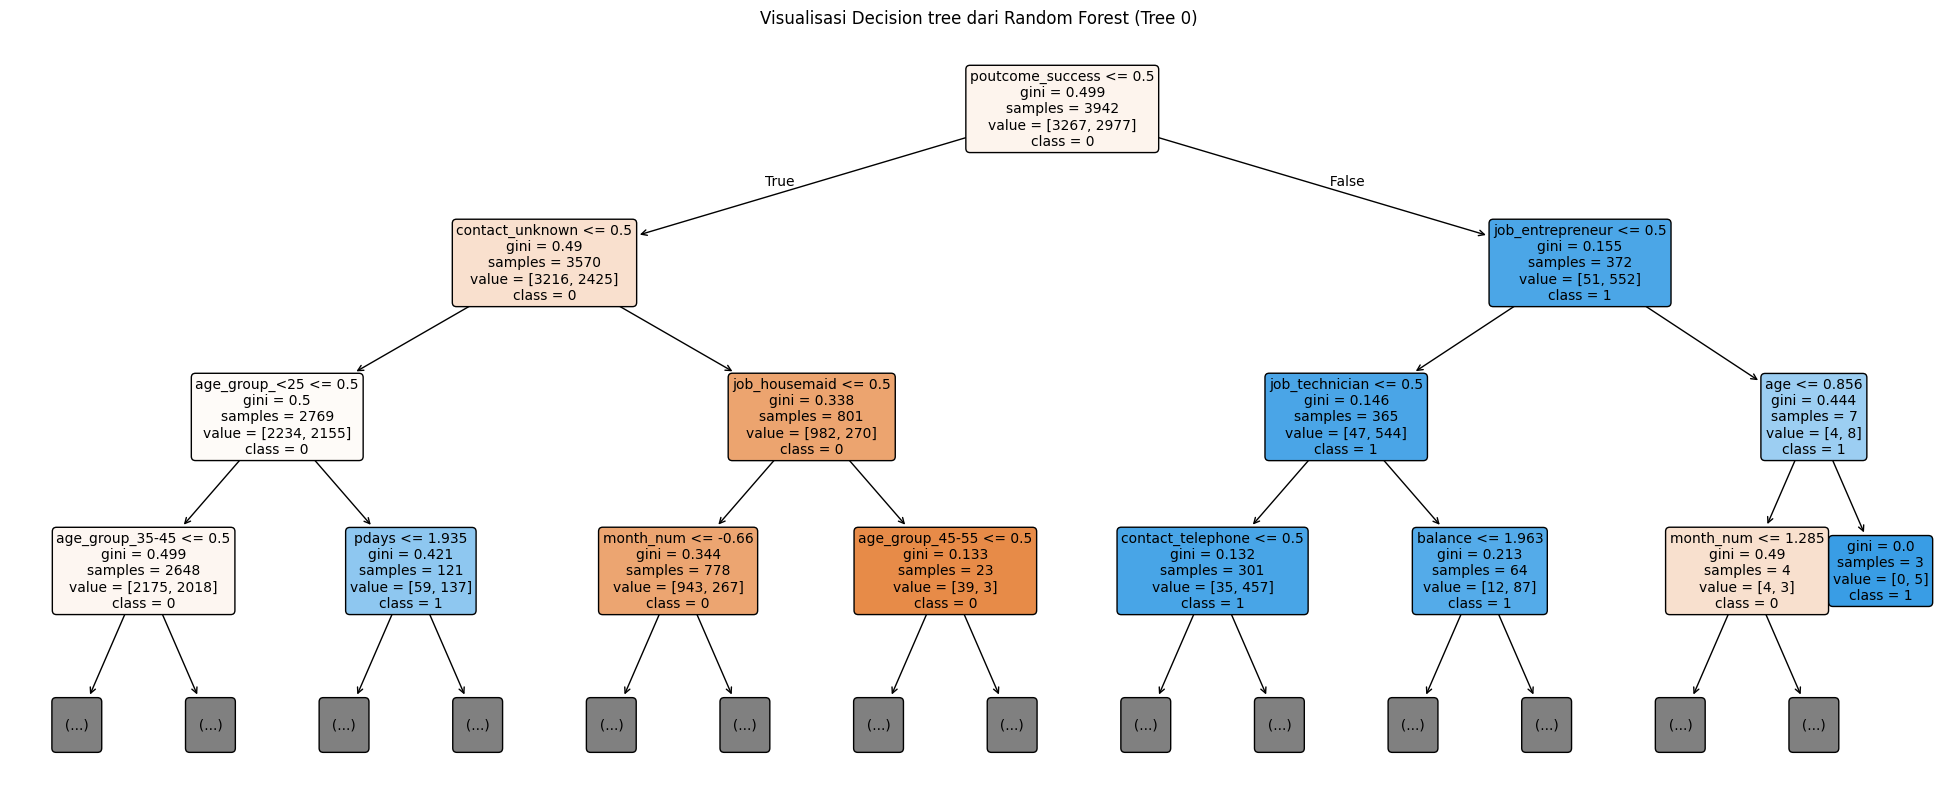

In [52]:
from sklearn.tree import plot_tree
import graphviz
from sklearn.tree import export_graphviz

# Ambil model random forest dari pipeline (pastikan 'classifier' adalah step-nya)
rf_model = best_pipeline.named_steps['classifier']

plt.figure(figsize=(25, 10))
plot_tree(rf_model.estimators_[0],
          feature_names=feature_names_shap,
          class_names=best_pipeline.named_steps['classifier'].classes_.astype(str),
          filled=True,
          rounded=True,
          max_depth=3, # Batasi kedalaman supaya mudah dibaca
          fontsize=10)
plt.title("Visualisasi Decision tree dari Random Forest (Tree 0)")
plt.show()

In [53]:
# Penambahan kolom probabilitas deposit untuk penjelasan skema cost and benefit

# y_proba = [P(tidak deposit), P(deposit)]
y_proba = best_pipeline.predict_proba(X_test)
x
# Ambil hanya probabilitas untuk kelas 'deposit' (biasanya label 1)
proba_deposit = y_proba[:, 1] * 100  # ubah ke persen

# Salin X_test agar tidak merusak aslinya
X_test_with_proba = X_test.copy()
X_test_with_proba['proba_deposit(%)'] = proba_deposit.round(2)

# Jika ingin menambahkan juga hasil prediksi:
X_test_with_proba['predicted_label'] = best_pipeline.predict(X_test)
X_test_with_proba['predicted_label'] = le.inverse_transform(X_test_with_proba['predicted_label'])

In [54]:
X_test_with_proba

,age,job,balance,housing,loan,contact,campaign,pdays,poutcome,month_num,was_contacted_previously,age_group,proba_deposit(%),predicted_label
5662,35,technician,204.0,yes,no,cellular,1.0,0,unknown,5,0,25-35,39.0,no
568,33,services,0.0,yes,no,cellular,2.0,0,unknown,5,0,25-35,36.0,no
5958,51,technician,130.0,no,no,cellular,3.0,0,unknown,8,0,45-55,36.5,no
7214,39,blue-collar,462.0,yes,no,cellular,1.0,0,unknown,5,0,35-45,7.5,no
2142,41,technician,128.0,yes,no,cellular,2.0,0,unknown,8,0,35-45,30.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5028,39,admin.,0.0,no,no,cellular,1.0,436,failure,1,1,35-45,54.0,yes
2152,29,management,983.0,yes,no,cellular,2.0,0,unknown,7,0,25-35,86.0,yes
6427,39,housemaid,70.0,no,no,cellular,2.0,128,success,6,1,35-45,84.0,yes
1912,37,housemaid,187.0,no,no,unknown,1.0,0,unknown,6,0,35-45,10.0,no


In [55]:
# Save file
X_test_with_proba.to_csv('hasil_prediksi_dengan_proba.csv', index=False)

In [56]:
# Save model
with open('best_model_deposit(rain forest).pkl', 'wb') as file:
    pickle.dump(best_pipeline, file)

print("Model berhasil disimpan")

Model berhasil disimpan


In [57]:
# download excel
from google.colab import files
files.download('hasil_prediksi_dengan_proba.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [58]:
# download model
files.download('best_model_deposit(rain forest).pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [59]:
# Pertimbangan Etis dan Mitigasi Bias
print("\n--- Pertimbangan Etis dan Mitigasi Bias ---")
print("Deteksi Bias: Ini adalah area yang kompleks dan memerlukan analisis lebih lanjut.")
print("- Analisis distribusi fitur sensitif (misal: 'age', 'marital', 'job') di antara kelas target.")
print("- Evaluasi metrik kinerja (Accuracy, Recall, Precision) secara terpisah untuk sub-kelompok demografi (misal: pria vs wanita, kelompok usia).")


--- Pertimbangan Etis dan Mitigasi Bias ---
Deteksi Bias: Ini adalah area yang kompleks dan memerlukan analisis lebih lanjut.
- Analisis distribusi fitur sensitif (misal: 'age', 'marital', 'job') di antara kelas target.
- Evaluasi metrik kinerja (Accuracy, Recall, Precision) secara terpisah untuk sub-kelompok demografi (misal: pria vs wanita, kelompok usia).
